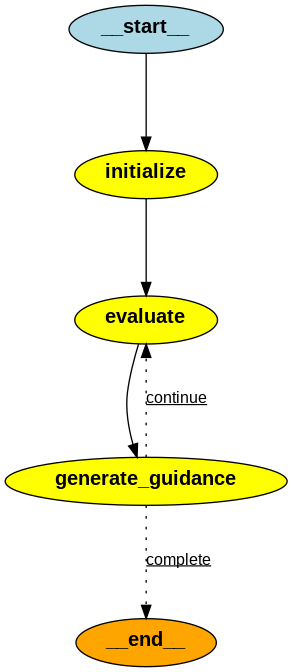

In [2]:
from IPython.display import Image, display
display(Image("graph.png"))

In [1]:
import os
os.environ["OPENAI_API_KEY"] = "sk-123"

In [2]:
from langchain.chat_models import init_chat_model
from langchain_core.prompts import ChatPromptTemplate
llm = init_chat_model(
    model="gpt-4o",
    model_provider="openai",
    temperature=0.3
)

In [5]:
# 1.关键点提取测试
extraction_prompt = ChatPromptTemplate.from_messages([     
    ("system", 
"""你是一个专业的教育专家，请根据以下问题分析对应的标准答案，提取出必须包含的关键信息点。
要求：
1. 每个关键点必须是独立的知识单元
2. 使用简洁的名词或名词短语表述
3. 按知识点的逻辑顺序排列
4. 包含答案的核心要素和必要细节
5. 不要提取答案之外的关键点，每个关键点必须在答案中存在

示例：
问题：光合作用的条件
答案：光合作用需要光照、二氧化碳和水作为原料，依赖叶绿体进行
关键点：光照、二氧化碳、水、叶绿体"""
     ), # TODO

    ("human", 
"""问题：{question}
标准答案：{answer}
请提取关键点（仅返回用、分隔的短语，不要编号）："""
     ) # TODO
])
extract_chain = extraction_prompt | llm
# resp = await extract_chain.ainvoke(
#     {"question": "计算机的工作原理",
#      "answer": "计算机基于冯诺依曼体系结构，通过输入设备接收指令和数据，由中央处理器执行运算，将结果存储在存储器中，最后通过输出设备展示结果"}
# )
resp = await extract_chain.ainvoke(
    {"question": "这个问题里面有几个对象。这里可以具体到对象的量。这些对象之中哪些是已知的，哪些是要求出来的。",
     "answer": "这里有我之前已经有的钱，具体到数量就是已有钱的数量（2元，已知，可以记作$O=2\text{（元）}$）；这里有爸爸新给我的钱，具体到数量就是新给的钱的数量（3元，已知，可以记作$N=3\text{（元）}$）；这里有我总共有的钱，具体到数量就是总共的钱的数量（未知，要求出来，可以记作$T=?\text{（元）}$）"}
)
resp.content

'已有钱的数量、爸爸新给的钱的数量、总共的钱的数量、2元、3元、未知'

In [ ]:
# 2.key points匹配模版
matching_prompt = ChatPromptTemplate.from_messages([

    ("system", 
"""请分析用户回答是否包含以下关键点（不要新增内容），按示例格式返回结果：
    
关键点列表：光照条件、二氧化碳、水、叶绿体、氧气生成、能量转换
回答："植物在阳光下吸收CO₂和H₂O"
匹配结果：光照条件、二氧化碳、水

请严格遵循以下规则：
1. 只匹配明确提及或隐含表达的关键点
2. 不要推断用户未表达的内容
3. 使用简体中文"""
    ), # TODO

    ("human", 
"""关键点列表：{key_points}
用户回答：{user_answer}
匹配结果（用、分隔的短语）："""
    ) # TODO
])
match_chain = matching_prompt | llm
resp = await match_chain.ainvoke(
    {"key_points": "冯诺依曼体系结构、输入设备、指令接收、数据接收、中央处理器、运算执行、存储器、结果存储、输出设备、结果展示",
     "user_answer": "电脑用cpu处理信息"}
)
resp.content

In [3]:
from typing import TypedDict, List

from langchain_core.prompts import ChatPromptTemplate
from langchain.chat_models import init_chat_model
from langgraph.graph import StateGraph, END

In [4]:
# 定义状态结构
class AgentState(TypedDict):
    question: str # 用户问题
    standard_answer: dict # 标准答案
    user_answer: str # 用户回答
    guide_llm_response: str # llm输出的引导式响应
    covered_points: List[str] # 标准答案提取的关键点
    missing_points: List[str] # 用户回答后根据covered_points缺失的关键点

In [5]:
extract_system_prompt = """你是一个专业的教育专家，请根据以下问题分析对应的标准答案，提取出必须包含的关键信息点。
要求：
1. 每个关键点必须是独立的知识单元
2. 使用简洁的名词或名词短语表述
3. 按知识点的逻辑顺序排列
4. 包含答案的核心要素和必要细节

示例：
问题：光合作用的条件
答案：光合作用需要光照、二氧化碳和水作为原料，依赖叶绿体进行，产生氧气和有机物
关键点：光照条件、二氧化碳、水、叶绿体、氧气生成、能量转换""" # TODO

extract_human_prompt = """问题：{question}
标准答案：{answer}
请提取关键点（仅返回用、分隔的短语，不要编号）：""" # TODO

match_system_prompt = """请分析用户回答是否包含以下关键点（不要新增内容），按示例格式返回结果：
    
关键点列表：光照条件、二氧化碳、水、叶绿体、氧气生成、能量转换
回答："植物在阳光下吸收CO₂和H₂O"
匹配结果：光照条件、二氧化碳、水

请严格遵循以下规则：
1. 只匹配明确提及或隐含表达的关键点
2. 不要推断用户未表达的内容
3. 使用简体中文""" # TODO

match_human_prompt = """关键点列表：{key_points}
用户回答：{user_answer}
匹配结果（用、分隔的短语）：""" # TODO

class KeyPointExtractor:
    """
    key point提取器
    """
    def __init__(self):
        self.llm = init_chat_model(
            model="gpt-4o",
            model_provider="openai",
            temperature=0.1
        )

        # 关键点提取模板
        self.extraction_prompt = ChatPromptTemplate.from_messages([
            ("system", extract_system_prompt),
            ("human", extract_human_prompt)
        ])

        # 关键点匹配模板
        self.matching_prompt = ChatPromptTemplate.from_messages([
            ("system", match_system_prompt),
            ("human", match_human_prompt)
        ])

    async def extract_standard_keypoints(self, question: str, answer: str) -> List[str]:
        chain = self.extraction_prompt | self.llm
        response = await chain.ainvoke({
            "question": question,
            "answer": answer
        })
        return self._clean_output(response.content)

    async def match_user_answer(self, key_points: List[str], user_answer: str) -> List[str]:
        chain = self.matching_prompt | self.llm
        response = await chain.ainvoke({
            "key_points": "、".join(key_points),
            "user_answer": user_answer
        })
        return self._clean_output(response.content)

    def _clean_output(self, text: str) -> List[str]:
        # 清洗模型输出
        cleaned = text.strip().replace("，", ",").replace("、", ",")
        return [kp.strip() for kp in cleaned.split(",") if kp.strip()]

In [6]:
# 初始化提取器
extractor = KeyPointExtractor()

# 在状态初始化时提取标准答案关键点
async def init_state(state: AgentState):
    if state.get("guide_llm_response"):
        return state

    # 提取标准答案关键点
    std_key_points = await extractor.extract_standard_keypoints(
        state["question"],
        state["standard_answer"]["answer"]
    )
 
    return {
        **state,
        "standard_answer": {
            **state["standard_answer"],
            "key_points": std_key_points
        },
        "covered_points": [],
        "missing_points": std_key_points.copy()
    }

async def evaluate_answer(state: AgentState):
    # 提取用户回答中的关键点
    user_points = await extractor.match_user_answer(
        state["standard_answer"]["key_points"],
        state["user_answer"]
    )
    
    # 对比逻辑保持不变
    new_covered = list(set(state["covered_points"] + user_points)) # 本次回答后的key point list
    new_missing = [p for p in state["standard_answer"]["key_points"]  # 还缺失的key point list
                  if p not in new_covered]
    
    return {
        "covered_points": new_covered,
        "missing_points": new_missing
    }

# 引导问题生成器
def generate_hint(question: str, covered_points: List[str]) -> str:
    hints = {
        "光合作用的条件": "除了{existing}，还有哪个重要因素参与了这个过程？", # TODO 可以使用template，也可以让LLM去生成一些有趣的提问,根据chracter来写prompt
        "光合作用的产物": "除了提到的产物，还产生了什么对大气重要的物质？",
        "能量转换过程": "这个过程中能量形式发生了怎样的转变？"
    }
    template = hints.get(question, "你觉得还有其它的要补充吗？") # TODO 这template不行
    return template.format(existing="、".join(covered_points))


# 生成引导问题
def generate_guidance(state: AgentState):
    if not state["missing_points"]:
        return {"guide_llm_response": "✅ 你已经完整回答了问题！"} # TODO 返回正确答案
    
    covered_points = state["covered_points"]

    hint = generate_hint(state["question"], covered_points)

    return {
        **state,
        "guide_llm_response": f"💡 {hint}"
    }

In [7]:
# 创建状态图
builder = StateGraph(AgentState)

# add节点
builder.add_node("initialize", init_state)
builder.add_node("evaluate", evaluate_answer)
builder.add_node("generate_guidance", generate_guidance)

# 设置graph edge
builder.set_entry_point("initialize")
builder.add_edge("initialize", "evaluate")
builder.add_edge("evaluate", "generate_guidance")
builder.add_conditional_edges(
    "generate_guidance",
    lambda state: END if not state["missing_points"] else "continue",
    {
        "continue": "evaluate",
        END: END
    }
)

# 完成图构建
critic_agent = builder.compile(interrupt_after=["generate_guidance"]) # interrupt_after会退出graph

In [ ]:
# 标准答案配置
standard_anwser = {
    "question": "光合作用的条件",
    "standard_answer": {
        "answer": "光合作用需要光照、二氧化碳和水作为原料，依赖叶绿体进行，产生氧气和有机物"
    }
}
            
# 初始化对话
initial_state = {
    **standard_anwser,
    "user_answer": "需要阳光和二氧化碳"  # 初始用户回答
}
print("user:", initial_state["user_answer"])

agent = critic_agent
state = initial_state
config = {"configurable": {"thread_id": "critic_agent"}}
while True:
    result = await agent.ainvoke(state)
    guide_llm_response = result["guide_llm_response"]
    print("assistant:", guide_llm_response)
    if "✅" in guide_llm_response:
        break

    new_user_answer = input("user:")
    state = {
        **result,
        "user_answer": new_user_answer
    }
